# Notebook to visualize networks generated and their statistics

## The focus in on the dependencies and how they vary with the chosen parameters

In [2]:
#  imports

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [45]:
# import the networks dataframe and visualize the first rows

networks_df = pd.read_pickle('/Users/federicasibilla/Downloads/Auxotrophs/generating_networks/generated_networks_df.pkl')
print(networks_df.head(1))
print(len(networks_df))

                   network_id  attempts  \
0  16_20_1_1_0.1_1.0_0.1_10_0         1   

                                          uptake_fac  \
0  [[1.1764052345967664, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                        uptake_oblig  \
0  [[1.1764052345967664, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                            spec_met  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   

                                             met_fac  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           met_oblig  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
660


## Visualize first row

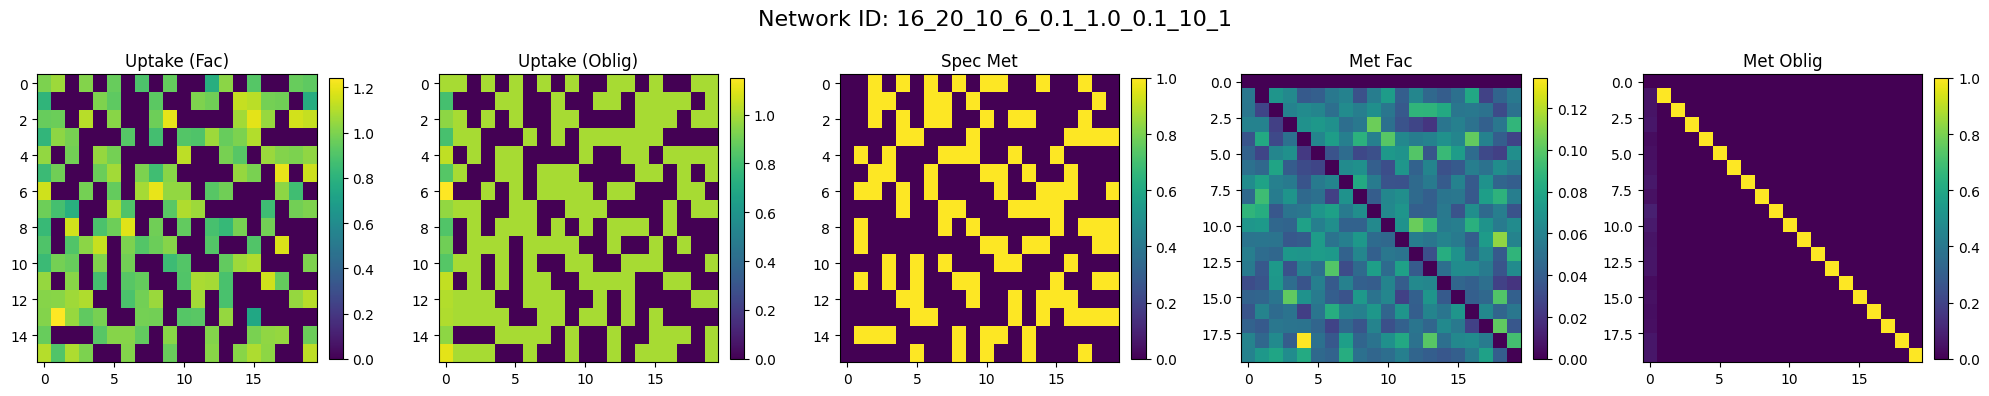

In [46]:
# Decompress the first row for example
row = networks_df.iloc[650]

uptake_fac = row['uptake_fac']
uptake_oblig = row['uptake_oblig']
spec_met = row['spec_met']
met_fac = row['met_fac']
met_oblig = row['met_oblig']

# Set up the plot
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Plot each matrix
titles = ['Uptake (Fac)', 'Uptake (Oblig)', 'Spec Met', 'Met Fac', 'Met Oblig']
mats = [uptake_fac, uptake_oblig, spec_met, met_fac, met_oblig]

for ax, mat, title in zip(axes, mats, titles):
    im = ax.imshow(mat, cmap='viridis', aspect='auto')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f"Network ID: {row['network_id']}", fontsize=16)
plt.tight_layout()
plt.show()

## Compute dependencies

In [47]:
from collections import defaultdict, deque

from itertools import combinations

def function_checking(uptake, production):
    n_species, n_resources = uptake.shape

    dep = []
    for i in range(n_species):  # for each focal species
        # Get the resources needed by the focal species
        needed_resources = uptake[i, 1:] > 0

        # Try all combinations of removing j species, other than the focal
        for j in range(1,n_species-1):
            collapse = []
            for combo in combinations([k for k in range(n_species) if k != i], j):
                # Create a mask to remove the species in the combination
                prod_mod = production.copy()[:,1:]
                for row in combo:
                    prod_mod[row]=np.zeros(production.shape[1]-1)

                # Calculate the sum of production without the removed species
                sum_production = np.sum(prod_mod, axis=0)

                # Check if the sum is non-zero in positions where uptake is non-zero
                if np.all(sum_production[needed_resources] > 0):
                    collapse.append(0)
                else:
                    collapse.append(1)
            if np.sum(collapse)==len(list(combinations([k for k in range(n_species) if k != i], j))):
                dep.append(n_species-j)
                break
            dep.append(1)

    return np.mean(dep) 

In [48]:
def greedy_function_checking(uptake, production):
    """
    Greedy approximation of dependency.
    
    uptake: (n_s, n_r) matrix where rows are species and columns are resources (1 if the species needs it)
    production: (n_s, n_r) matrix where rows are species and columns are resources (1 if the species produces it)

    Returns: average number of species needed to support each focal species
    """
    n_s, n_r = uptake.shape
    dep = []

    for i in range(n_s):  # for each focal species
        needed = set(np.where(uptake[i, 1:] > 0)[0])  # Needed resource indices (excluding PCS)
        remaining = set(range(n_s)) - {i}  # All other species
        covered = set(np.where(production[i, 1:] > 0)[0])  # What focal already produces

        required = needed - covered  # What it still needs
        support_set = set()

        while required and remaining:
            best = None
            best_coverage = 0

            for j in remaining:
                prod = set(np.where(production[j, 1:] > 0)[0])
                coverage = len(required & prod)

                if coverage > best_coverage:
                    best = j
                    best_coverage = coverage

            if best is None:
                # No one can help anymore, unmet needs remain
                break

            support_set.add(best)
            remaining.remove(best)
            required -= set(np.where(production[best, 1:] > 0)[0])

        dep.append(len(support_set))

    return np.mean(dep)

In [49]:
networks_df['dep']=networks_df.apply(lambda row: greedy_function_checking(row['uptake_fac'],row['spec_met']),axis=1)

In [50]:
# extract n_producers and n_consumed 

# Assuming your DataFrame is named df
networks_df[['n_consumed', 'n_producers']] = networks_df['network_id'].str.split('_', expand=True).iloc[:, 2:4].astype(int)

# Display the updated DataFrame
print(networks_df.head(1))

                   network_id  attempts  \
0  16_20_1_1_0.1_1.0_0.1_10_0         1   

                                          uptake_fac  \
0  [[1.1764052345967664, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                        uptake_oblig  \
0  [[1.1764052345967664, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                            spec_met  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   

                                             met_fac  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           met_oblig  dep  n_consumed  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1.0           1   

   n_producers  
0            1  


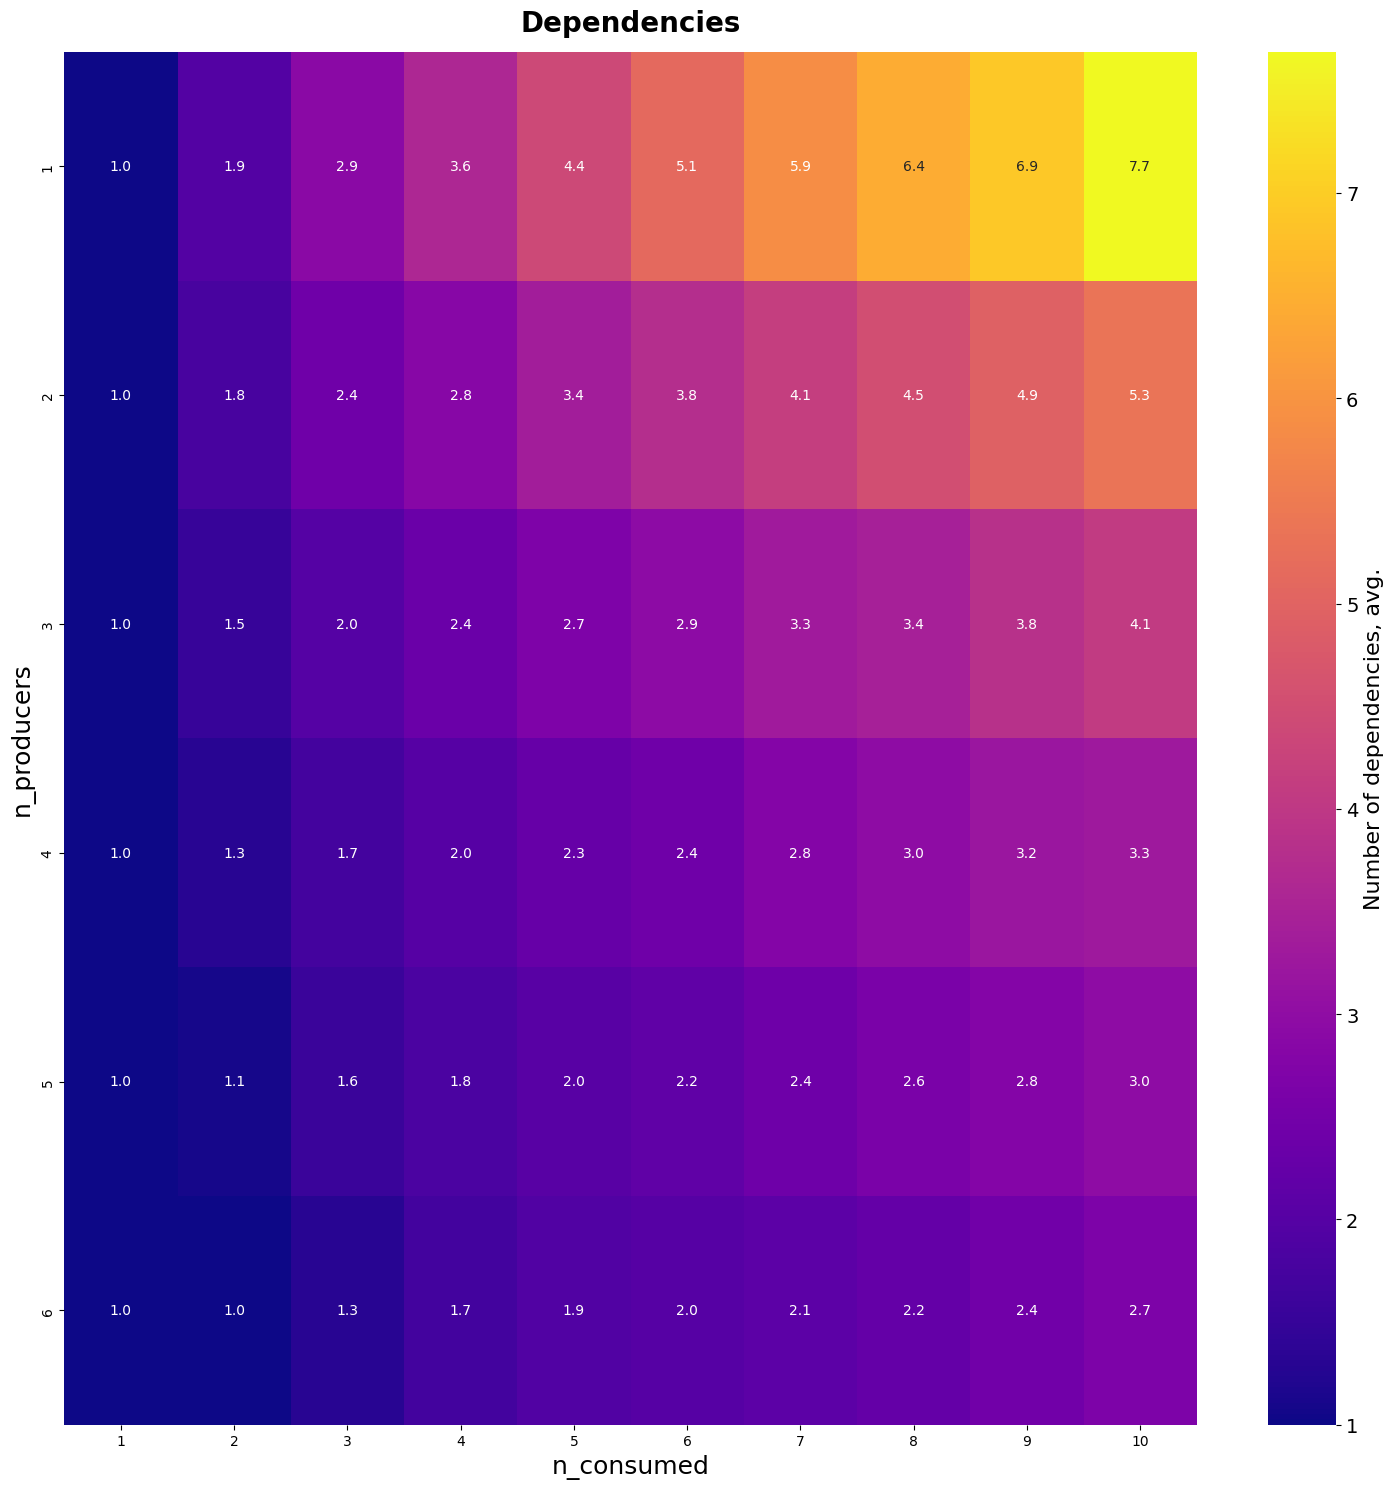

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_space_F is already defined and contains the relevant columns

# Pivot the data for heatmap
heatmap_data = networks_df.pivot_table(index='n_producers', columns='n_consumed', values='dep')

# Create the figure
plt.figure(figsize=(15, 15))

# Create the heatmap
sns.heatmap(heatmap_data, cmap="plasma", annot=True, fmt=".1f", cbar=True)

# Improve styling
plt.title('Dependencies', fontsize=20, fontweight='bold', pad=15)
plt.xlabel('n_consumed', fontsize=18)
plt.ylabel('n_producers', fontsize=18)

# Create an axis for the colorbar
cbar = plt.gca().collections[0].colorbar
cbar.set_label('Number of dependencies, avg.', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Row and column redundancy

In [52]:
networks_df['n_produced']=networks_df.apply(lambda row: np.mean(np.sum(row['spec_met'][:,1:],axis=1)),axis=1)

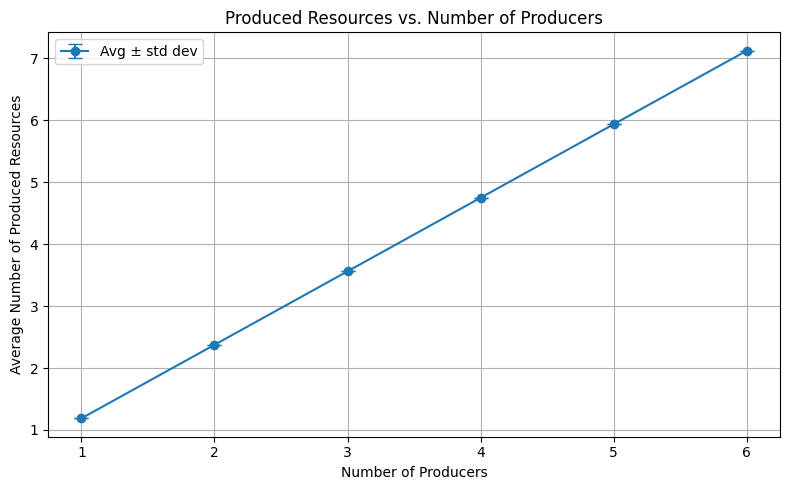

In [53]:
# Group by n_producers and compute mean and std of n_produced
grouped = networks_df.groupby('n_producers')['n_produced'].agg(['mean', 'std']).reset_index()

# Plot the average with standard deviation as y-error
plt.figure(figsize=(8, 5))
plt.errorbar(
    grouped['n_producers'],     # x values
    grouped['mean'],            # y values (average n_produced)
    yerr=grouped['std'],        # error bars (std dev)
    fmt='o-',                   # points connected with lines
    capsize=5,                  # cap size on error bars
    label='Avg ± std dev'
)

plt.xlabel('Number of Producers')
plt.ylabel('Average Number of Produced Resources')
plt.title('Produced Resources vs. Number of Producers')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
networks_df.index

RangeIndex(start=0, stop=660, step=1)